In [9]:
import jax
from jax import numpy as jnp, random
import numpy as np
import pandas as pd
from mondeq.modules import MonLinear, Relu, fcmon
from mondeq.splittings import build_peacemanrachford_update
from utils import commutation_matrix_sp, vec
from functools import partial
import pandas as pd

In [50]:
dyn = partial(build_peacemanrachford_update, 1.)
def stats_TK(d, k, Z0, X, key):
    X = X / jnp.linalg.norm(X, axis=0)

    skey = random.split(key)
    lin_module = MonLinear(d, k, key=skey[0])
    nonlin_module = Relu()
    u = random.normal(skey[1], shape=(k,)) / jnp.sqrt(k)
    Ju = jax.jacrev(lambda u: fcmon(dyn, max_iter, tol, u, nonlin_module, lin_module, Z0, X))(u)
    Jlin = jax.jacrev(lambda lin_module: fcmon(dyn, max_iter, tol, u, nonlin_module, lin_module, Z0, X), allow_int=True)(lin_module)
    
    H1_A = vprod(Jlin.p_A)
    H1_B = vprod(Jlin.p_B)

    H1 = H1_A + H1_B
    H2 = vprod(Jlin.p_U)
    H3 = Ju @ Ju.T
    H = H1 + H2 + H3
    return {
        "min_norm_row_Q": jnp.min(jnp.diag(H2)),
        "eigmin_H1_A": jnp.linalg.eigvalsh(H1_A)[0],
        "eigmin_H1_B": jnp.linalg.eigvalsh(H1_B)[0],

        "eigmin_H1": jnp.linalg.eigvalsh(H1)[0],
        "eigmin_H2": jnp.linalg.eigvalsh(H2)[0],
        "eigmin_H3": jnp.linalg.eigvalsh(H3)[0],

        "eigmin_H": jnp.linalg.eigvalsh(H)[0],
    }
stats_TK_jit = jax.jit(stats_TK, static_argnums=(0, 1))

In [85]:
num_runs = 1000
num_samples = 100
d = 20
k = 100
key = random.PRNGKey(0)
max_iter = 40
tol = 1e-5
def vprod(M):
    return jnp.einsum("ihk,jhk->ij", M, M)

In [86]:
Z0 = jnp.zeros(shape=(num_samples, k))
row_list = []
for i in range(num_runs):
    key, skey = random.split(key)
    X = np.random.uniform(size=(num_samples, d))
    result = stats_TK_jit(d, k, Z0, X, skey)
    result = {k: v.item() for k, v in result.items()}
    row_list.append(result)
df = pd.DataFrame(row_list)

In [87]:
df  

,eigmin_H,eigmin_H1,eigmin_H1_A,eigmin_H1_B,eigmin_H2,eigmin_H3,min_norm_row_Q
0,0.010144,0.005412,0.001845,0.003245,0.003351,-7.252503e-08,0.038359
1,0.010030,0.005161,0.001949,0.002946,0.003481,-2.366923e-06,0.067830
2,0.013641,0.007624,0.002457,0.004600,0.004679,-1.297095e-07,0.080472
3,0.009618,0.004614,0.001641,0.002693,0.003172,-1.350228e-07,0.038995
4,0.009679,0.005354,0.001848,0.003247,0.003181,-8.066259e-08,0.045554
...,...,...,...,...,...,...,...
995,0.014702,0.009073,0.002975,0.005637,0.004090,-1.710344e-07,0.067376
996,0.007401,0.004068,0.001468,0.002432,0.002449,-1.517791e-06,0.040256
997,0.009292,0.004465,0.001652,0.002494,0.003259,-5.376862e-08,0.048764
998,0.007286,0.003705,0.001409,0.002136,0.002635,-9.797255e-08,0.051726


In [88]:
df.min()

eigmin_H          0.002472
eigmin_H1         0.001187
eigmin_H1_A       0.000418
eigmin_H1_B       0.000728
eigmin_H2         0.000764
eigmin_H3        -0.000004
min_norm_row_Q    0.015154
dtype: float64

In [89]:
df.mean()

eigmin_H          1.036051e-02
eigmin_H1         5.418245e-03
eigmin_H1_A       1.892026e-03
eigmin_H1_B       3.233619e-03
eigmin_H2         3.420171e-03
eigmin_H3        -1.786486e-07
min_norm_row_Q    5.752994e-02
dtype: float64

<AxesSubplot:ylabel='Frequency'>

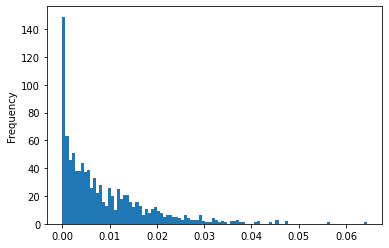

In [72]:
df.eigmin_H.plot.hist(bins=100)

In [79]:
df.min()

eigmin_H          1.223016e-06
eigmin_H1         7.194511e-07
eigmin_H1_A       2.549738e-07
eigmin_H1_B       4.750988e-07
eigmin_H2         2.368104e-07
eigmin_H3         7.847345e-10
min_norm_row_Q    7.859664e-04
dtype: float64

<AxesSubplot:ylabel='Frequency'>

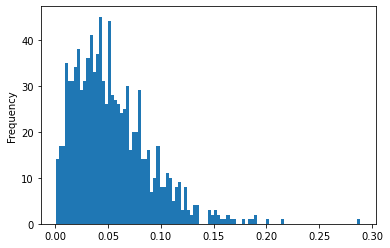

In [73]:
df.min_norm_row_Q.plot.hist(bins=100)

In [92]:
(df.eigmin_H < df.eigmin_H.min()*2).sum()

27